# Training Notebook for BirdCLEF2023

## Import all Dependencies (1)

In [1]:
import torch
import torchvision
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics
from tqdm import tqdm

import os
import sys
import random
import time
import copy
import logging
import bisect
import json
import shutil

/home/colin/elec5305/ele5305_research_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define a CONFIG class containing all relevant hyperparameters

In [2]:
### DO NOT CHANGE UNLESS RE-GENERATING DATASET IMAGES ###
class Config_Mel():
    def __init__(self) -> None:
        
        # Device
        self.device = 'cpu'
        
        # Dataset Path
        self.birdclef2023 = 'birdclef-2023'

        # Out path
        self.outpath_images = self.birdclef2023 + '_MelSpectrograms'

        self.melSpecTransform = torchaudio.transforms.AmplitudeToDB()

        # Audio Features
        self.sample_rate = 32000
        self.n_fft=2048
        self.f_min=40
        self.f_max=15000
        self.hop_length=512
        self.n_mels=128
        self.mel_args = {'sample_rate': self.sample_rate,
                         'n_fft': self.n_fft,
                         'f_min': self.f_min,
                         'f_max': self.f_max,
                         'hop_length': self.hop_length,
                         'n_mels': self.n_mels}
### DO NOT CHANGE UNLESS RE-GENERATING DATASET IMAGES ###

class Config():
    def __init__(self) -> None:

        self.run_environment = 'local' # 'kaggle' 'local' 'colab'
        self.load_pretrained_weights = True
        self.rerun_split = False

        # Device
        if (self.run_environment == 'kaggle') or (self.run_environment == 'colab'):
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        # Dataset Path
        self.birdclef2023 = 'birdclef-2023'
        if self.run_environment == 'kaggle':
            self.birdclef2023_melspectrograms = '/kaggle/input/birdclef-2023-melspectrograms/birdclef-2023_MelSpectrograms'
        elif self.run_environment == 'local':
            self.birdclef2023_melspectrograms = '/home/colin/elec5305/ele5305_research_project/birdclef-2023_MelSpectrograms'
        elif self.run_environment == 'colab':
            self.birdclef2023_melspectrograms = ''

        # Out path
        if self.run_environment == 'kaggle':
            self.outpath = '/kaggle/working/results'
        elif self.run_environment == 'local':
            self.outpath = 'results'
        elif self.run_environment == 'colab':
            self.outpath = ''

        # Train/Validation Split 
        self.val_frac = 0.1

        # Dataloader options
        self.num_workers = 2
        self.train_batch_size = 64
        self.valid_batch_size = 32

        # Model name
        self.model_name = 'tf_efficientnet_b0_ns'
        # Pretrained
        if self.run_environment == 'kaggle':
            self.pretrained_weights = '/kaggle/input/weigths/model_weights.pth'
        elif self.run_environment == 'local':
            self.pretrained_weights = '/home/colin/elec5305/ele5305_research_project/weights/model_weights.pth'


        # Optimizer Settings
        self.lr=5e-4
        self.weight_decay = 1e-3
        self.momentum=0.9
        self.criterion = nn.BCEWithLogitsLoss
        self.optimizer = 'adam' # 'adam', 'sgd'

        self.scheduler = 'cosineannealing'
        self.eta_min = 1e-6
        self.T_mult = 1
        self.last_epoch = -1

        self.use_mixup = True
        self.mixup_alpha = 0.2 

        # Training Settings
        self.epochs = 10
        self.print_every_n_batches = 25
        self.patience = 3
        self.fix_features = False

        # Image Transforms
        self.train_transforms = torchvision.transforms.Compose([
                    transforms.ToTensor(),
                    # torchvision.transforms.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
                    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
        
        self.val_transforms = torchvision.transforms.Compose([
                    transforms.ToTensor(),
                    # torchvision.transforms.Resize(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
                    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
        
        self.test_transforms = torchvision.transforms.Compose([
                    transforms.ToTensor(),
                    # torchvision.transforms.Resize(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
                    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

        # Audio Transforms
        self.train_transforms_audio = None
        
        self.val_transforms_audio = None
        
        self.test_transforms_audio = None


        # Audio Features
        self.sample_rate = 32000
        self.period = 5

        # Mel Spectrogram Parameters
        self.n_fft=2048
        self.f_min=40
        self.f_max=15000
        self.hop_length=512
        self.n_mels=128
        self.mel_args = {'n_fft': self.n_fft,
                         'f_min': self.f_min,
                         'f_max': self.f_max,
                         'hop_length': self.hop_length,
                         'n_mels': self.n_mels}
        
CONFIG = Config()

In [3]:
if CONFIG.run_environment == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    notebook_path = 'My Drive/elec5305'

    env_path = f'/content/drive/{notebook_path}'
    # Add the handout folder to python paths
    if env_path not in sys.path:
        sys.path.append(env_path)

    # zip_path = os.path.join(env_path, 'birdclef-2023_MelSpectrograms.zip')
    zip_path = '/content/drive/MyDrive/elec5305/birdclef-2023_MelSpectrograms.zip'
    shutil.unpack_archive(zip_path, "content/")
    print(zip_path)
    # !unzip zip_path -d "/content"

    # Dataset path
    CONFIG.birdclef2023_melspectrograms = '/content/content/birdclef-2023_MelSpectrograms'

    # Output path
    CONFIG.outpath = os.path.join(env_path, 'results')
    os.makedirs(CONFIG.outpath, exist_ok=True)

    %pip install timm torchtoolbox

## Import all dependencies (2)

In [4]:
# !pip install --force-reinstall numpy==1.22.1
%pip install -q torchtoolbox timm

from torchtoolbox.tools import mixup_data, mixup_criterion
from torch.nn.functional import cross_entropy
import timm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Define Network

In [6]:
class Mel_Classifier(torch.nn.Module):
    def __init__(self, model_name, num_classes = 264, pretrained = True):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )

    def forward(self,x):
        x = self.backbone(x)
        return x

## Create a Dataloader Class

In [7]:
class BirdCLEF2023_MelSpec_Dataset(torch.nn.Module):
    def __init__(self, dataset_path, train_flag = None, inherited_species_list = None,*args, **kwargs) -> None:

        # Default values
        self.sample_rate = kwargs.get('sample_rate', 32000)
        self.n_fft = kwargs.get('n_fft', 2048)
        self.f_min = kwargs.get('f_min', 40)
        self.f_max = kwargs.get('f_max', 15000)
        self.hop_length = kwargs.get('hop_length', 512)
        self.n_mels = kwargs.get('n_mels', 128)
        self.period = kwargs.get('period', 5)
        self.device = kwargs.get('device', 'cpu')
        self.transform = kwargs.get('transform', transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]))
         
        # Save path of dataset
        self.datapath = dataset_path

        # Get metadata
        if train_flag is None:
            csv_name = 'train_metadata.csv'
        elif train_flag == 'train':
            csv_name = 'TRAIN_train_metadata.csv'
        elif train_flag == 'valid':
            csv_name = 'VALID_train_metadata.csv'

        self.df = pd.read_csv(os.path.join(dataset_path, csv_name))

        # Get species list
        if inherited_species_list is None:
            self.species = list(set(self.df['primary_label']))
        else:
            self.species = inherited_species_list

        # Get time per pixel
        self.time_per_pixel = self.hop_length / self.sample_rate

        # Image Width
        self.new_width = int(self.period / self.time_per_pixel)

        # Get number of cut images per full image
        self.get_shortened_image()
        
        return
    

    def get_shortened_image(self):

        old_len = len(list(self.df['primary_label']))
        number_of_images_per_image = [0] * old_len

        cumulative_images_count = 0
        cumulative_list = [0] * old_len

        for i in tqdm(range(old_len), desc="Processing Images"):
            dict_idx = dict(self.df.iloc[i])

            # Load image
            rel_img_path = dict_idx['image_path']
            ful_img_path = os.path.join(self.datapath,rel_img_path)
            image = Image.open(ful_img_path)

            # Get image shape
            width, height = image.size

            # How many images of self.period length fit in image?
            n_imgs = width // self.new_width

            # Put to list
            number_of_images_per_image[i] = n_imgs

            # Calculate the cumulative count
            cumulative_images_count += n_imgs

            # Put to list
            cumulative_list[i] = cumulative_images_count - 1

        # Add number_of_images_per_image as a new column to the DataFrame
        self.df['cumulative_images'] = cumulative_list

        return
    

    def __len__(self):
        # length = self.df['cumulative_images'][-1]
        length = self.df['cumulative_images'].iloc[-1]
        return length


    def __getitem__(self, idx):

        # Get the 'cumulative_list' values as a sorted list
        cumulative_list_values = self.df['cumulative_images'].tolist()

        # Use binary search to find the index of the next smallest value to idx
        row_index = bisect.bisect_left(cumulative_list_values, idx)
        cumulative_value_left = 0
        if row_index == 0:
            cumulative_value_left = 0
        else:
            cumulative_value_left = self.df['cumulative_images'].iloc[row_index-1] + 1
        sub_idx = idx - cumulative_value_left

        # Get row in df
        dict_idx = dict(self.df.iloc[row_index])

        # Calculate image crop start pixel based on sub_idx
        px_start = sub_idx * self.new_width

        # Get labels as torch tensors
        primary_label = torch.tensor([1 if dict_idx['primary_label'] == label else 0 for label in self.species],dtype=float)
        secondary_label = torch.tensor([1 if label in dict_idx['secondary_labels'] else 0 for label in self.species], dtype=float)
        combined_label = self._prepare_target(main_tgt=primary_label, sec_tgt=secondary_label)
        dict_idx['combined_label_tensor'] = combined_label
        dict_idx['primary_label_tensor'] = primary_label
        dict_idx['secondary_label_tensor'] = secondary_label

        # Load image
        rel_img_path = dict_idx['image_path']
        ful_img_path = os.path.join(self.datapath,rel_img_path)
        image = Image.open(ful_img_path)
        image = self.crop_image(image = image, startPixel = px_start)
        if self.transform is not None:
            image = self.transform(image)
        dict_idx['mel_spec'] = image
    
        return image.float(), primary_label.float()
    

    def crop_image(self, image, startPixel):
        image = image.crop((startPixel, 0, startPixel + self.new_width, image.height))
        return image


    # https://github.com/VSydorskyy/BirdCLEF_2023_1st_place/blob/main/code_base/datasets/wave_dataset.py, changed
    def _prepare_target(self, main_tgt, sec_tgt, all_labels=None):
        all_tgt = main_tgt + sec_tgt
        all_tgt = torch.clamp(all_tgt, 0.0, 1.0)
        return all_tgt

## Create a Training/Validation Split Scheme

In [8]:
# https://www.kaggle.com/code/nischaydnk/split-creating-melspecs-stage-1
def birds_stratified_split(df, target_col, test_size=0.2):
    class_counts = df[target_col].value_counts()
    low_count_classes = class_counts[class_counts < 2].index.tolist() ### Birds with single counts

    df['train'] = df[target_col].isin(low_count_classes)

    train_df, val_df = train_test_split(df[~df['train']], test_size=test_size, stratify=df[~df['train']][target_col], random_state=42)

    train_df = pd.concat([train_df, df[df['train']]], axis=0).reset_index(drop=True)

    # Remove the 'valid' column
    train_df.drop('train', axis=1, inplace=True)
    val_df.drop('train', axis=1, inplace=True)

    return train_df, val_df


def save_df_as_csv(df, csv_name):
    df.to_csv(csv_name, index=False)
    return


def create_split_and_save(df_path, val_frac):

    # Load dataframe
    df = pd.read_csv(os.path.join(df_path, 'train_metadata.csv'))

    # Get Split
    train_df, val_df = birds_stratified_split(df=df, target_col='primary_label', test_size=val_frac)

    # Save metadata
    os.path.join(df_path, 'TRAIN_train_metadata.csv')
    save_df_as_csv(train_df, os.path.join(df_path, 'TRAIN_train_metadata.csv'))
    save_df_as_csv(val_df, os.path.join(df_path, 'VALID_train_metadata.csv'))

    return

In [9]:
if CONFIG.rerun_split == True:
    create_split_and_save(df_path=CONFIG.birdclef2023_melspectrograms, val_frac=CONFIG.val_frac)

## Make Datasets and Dataloaders

In [10]:
# Get species list
df_all = pd.read_csv(os.path.join(CONFIG.birdclef2023_melspectrograms, 'train_metadata.csv'))
species_list = list(set(df_all['primary_label']))

# Initialize Datasets
train_class_kwargs = {  'sample_rate': CONFIG.sample_rate,
                        'n_fft': CONFIG.n_fft,
                        'f_min': CONFIG.f_min,
                        'f_max': CONFIG.f_max,
                        'hop_length': CONFIG.hop_length,
                        'n_mels': CONFIG.n_mels,
                        'period': CONFIG.period,
                        'device': CONFIG.device,
                        'transform': CONFIG.train_transforms
                     }

valid_class_kwargs = {   'sample_rate': CONFIG.sample_rate,
                        'n_fft': CONFIG.n_fft,
                        'f_min': CONFIG.f_min,
                        'f_max': CONFIG.f_max,
                        'hop_length': CONFIG.hop_length,
                        'n_mels': CONFIG.n_mels,
                        'period': CONFIG.period,
                        'device': CONFIG.device,
                        'transform': CONFIG.val_transforms
                    }

train_dataset = BirdCLEF2023_MelSpec_Dataset(CONFIG.birdclef2023_melspectrograms, inherited_species_list = species_list, **train_class_kwargs, train_flag='train')
valid_dataset = BirdCLEF2023_MelSpec_Dataset(CONFIG.birdclef2023_melspectrograms, inherited_species_list = species_list, **valid_class_kwargs, train_flag='valid')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,num_workers=CONFIG.num_workers, batch_size=CONFIG.train_batch_size, shuffle = True, pin_memory = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,num_workers=CONFIG.num_workers, batch_size=CONFIG.valid_batch_size, shuffle = True, pin_memory = True)

Processing Images:   3%|▎         | 443/15247 [00:00<00:03, 4420.90it/s]

Processing Images: 100%|██████████| 1694/1694 [00:00<00:00, 5232.64it/s]


### Visualize some spectrograms

In [11]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        dict_idx = img_ds[img_index]        
        img, lb = dict_idx    
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

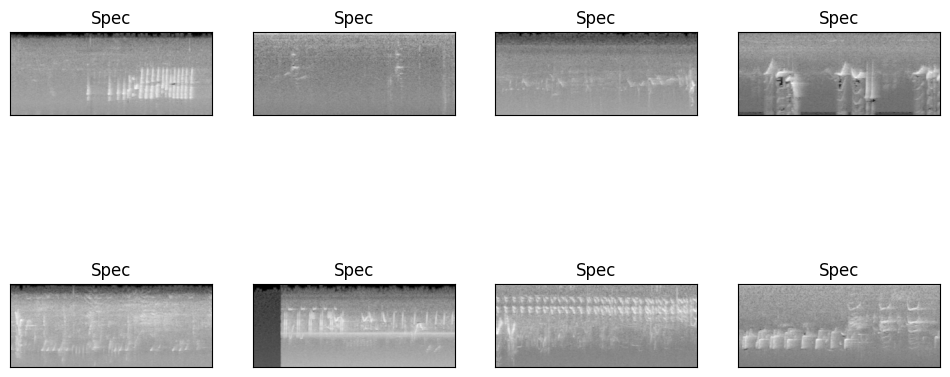

In [12]:
show_batch(train_dataset, 8, 2, 4)

## Define Metric Function as on Kaggle

In [13]:
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution.drop(['row_id'], axis=1, errors='ignore')
    submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

## Define Training Function

In [14]:
def create_logger(final_output_path):
    log_file = '{}.log'.format(time.strftime('%Y-%m-%d-%H-%M'))
    head = '%(asctime)-15s %(message)s'
    logging.basicConfig(filename=os.path.join(final_output_path, log_file),
                        format=head)
    clogger = logging.getLogger()
    clogger.setLevel(logging.INFO)
    # add handler
    # print to stdout and log file
    ch = logging.StreamHandler(sys.stdout)
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    clogger.addHandler(ch)
    return clogger

def train_with_mixup(X, y, y_pred):
    X, y_a, y_b, lam = mixup_data(X, y, alpha=CONFIG.mixup_alpha)
    loss_mixup = mixup_criterion(cross_entropy, y_pred, y_a, y_b, lam)
    return loss_mixup

def train_net(net, trainloader, valloader, logging, criterion, optimizer, scheduler, epochs=1, patience = 3, savePth = 'project2_weights.pth', print_every_samples = 20, device = 'cpu'):

    logging.info('Using device: {}'.format(device))
    net.to(device)

    validation_loss_list = [0] * epochs
    training_loss_list = [0] * epochs
    validation_accuracy_list = [0] * epochs
    training_accuracy_list = [0] * epochs
    cmap_5_list = [0] * epochs

    best_state_dictionary = None
    best_validation_accuracy = 0.0
    inertia = 0
    for epoch in range(epochs):

        training_loss = 0.0
        training_accuracy = 0.0
        running_loss = 0.0
        net = net.train()
        with tqdm(enumerate(trainloader, 0), total=len(trainloader), desc="Training Batches Epoch {} / {}".format(epoch, epochs)) as train_pbar:
            for i, data in train_pbar:
                # get the inputs
                if device == 'cuda':
                    inputs, labels = data[0].to(device), data[1].to(device)
                else:
                    inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)

                if CONFIG.use_mixup:
                    loss_value = train_with_mixup(inputs, labels, outputs)
                else:
                    loss_value = criterion(outputs,labels)

                loss_value.backward()
                optimizer.step()

                # print statistics and write to log
                running_loss += loss_value.item()
                training_loss += loss_value.item()

                train_pbar.set_postfix(loss=(running_loss / ((i + 1) * trainloader.batch_size)))
                # training_accuracy += (outputs.item().argmax(1) == labels.item().argmax(1)).sum()
                training_accuracy += (outputs.argmax(1) == labels.argmax(1)).sum().item()

        if type(scheduler).__name__ != 'NoneType':
            scheduler.step()

        training_loss = training_loss / len(trainloader.dataset)
        training_loss_list[epoch] = training_loss
        training_accuracy = 100 * training_accuracy / len(trainloader.dataset)
        training_accuracy_list[epoch] = training_accuracy

        logging.info('Batch {:5d} / {:5d}: Training Loss = {:.3f}, Training Accuracy = {:.3f}'.format(epoch, epochs, training_loss, training_accuracy))

        running_loss = 0.0
        val_loss = 0.0
        correct = 0
        predictions_array = np.zeros((len(valloader.dataset), len(valloader.dataset.species)), dtype=float)
        solutions_array = np.zeros((len(valloader.dataset), len(valloader.dataset.species)), dtype=float)
        net = net.eval()
        with tqdm(enumerate(valloader, 0), total=len(valloader), desc="Validation Batches Epoch {} / {}".format(epoch, epochs)) as val_pbar:
            for i, data in val_pbar:
                # get the inputs
                if device == 'cuda':
                    inputs, labels = data[0].to(device), data[1].to(device)
                else:
                    inputs, labels = data
                    
                # forward + backward + optimize
                outputs = net(inputs)
                loss_value = criterion(outputs, labels)

                # print statistics and write to log
                running_loss += loss_value.item()
                val_loss += loss_value.item()

                # Get model output and label to array
                curr_predictions_array = outputs.detach().cpu().numpy()
                predictions_array[i*valloader.batch_size:(i+1)*valloader.batch_size,:] = curr_predictions_array
                curr_solutions_array = labels.detach().cpu().numpy()
                solutions_array[i*valloader.batch_size:(i+1)*valloader.batch_size,:] = curr_solutions_array

                # Update progress bar
                val_pbar.set_postfix(loss=(running_loss / ((i + 1) * trainloader.batch_size)))
                correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()
        
        # Get cMAP
        cmap_5 = padded_cmap(solution=pd.DataFrame(solutions_array), submission=pd.DataFrame(predictions_array), padding_factor=5)

        # Get Metrics
        val_loss = val_loss / len(valloader.dataset)
        validation_loss_list[epoch] = val_loss
        val_accuracy = 100 * correct / len(valloader.dataset)
        validation_accuracy_list[epoch] = val_accuracy
        cmap_5_list[epoch] = cmap_5

        logging.info('Batch {:5d} / {:5d}: Validation Loss = {:.3f}, Validation Accuracy = {:.3f}, cmap score = {:.3f}'.format(epoch, epochs, val_loss, val_accuracy, cmap_5))

        save_weights = os.path.join(savePth,'model_weights.pth')
        if val_accuracy > best_validation_accuracy:
            best_state_dictionary = copy.deepcopy(net.state_dict())
            # save network
            torch.save(best_state_dictionary, save_weights)
            inertia = 0
            logging.info('Epoch %5d / %5d saved: New Best Epoch!')
        else:
            inertia += 1
            if inertia == patience:
                if best_state_dictionary is None:
                    raise Exception("State dictionary should have been updated at least once")
                break
        print(f"Validation accuracy: {val_accuracy}")

    logging.info('Finished Training')

    output = {'validation_loss': validation_loss_list,
              'validation_accuracy': validation_accuracy_list,
              'training_loss': training_loss_list,
              'training_accuracy': training_accuracy_list,
              'cmap_5_scores': cmap_5_list}
    
    return output

## Run Training Procedure

In [15]:
def main_train():

    # Change Output path
    folder_name = time.strftime('%Y-%m-%d_%H-%M-%S')
    outpath = os.path.join(CONFIG.outpath, folder_name)
    CONFIG.outpath = outpath
    # Create Output directory
    os.makedirs(CONFIG.outpath, exist_ok=True)

    # Create Logger
    logger = create_logger(final_output_path=CONFIG.outpath)

    # Get all variable to logger
    logger.info('############################################ START CONFIG FILE ############################################')
    for attr, value in vars(CONFIG).items():
        logger.info(f"{attr}: {value}")
    logger.info('############################################  END CONFIG FILE  ############################################')

    network = Mel_Classifier(model_name=CONFIG.model_name)
    if CONFIG.load_pretrained_weights == True:
        logger.info('Load PreTrained Weigths')
        network.load_state_dict(torch.load(CONFIG.pretrained_weights))

    if CONFIG.fix_features == True:
        for param in network.backbone.parameters():
            param.requires_grad = False

    criterion = CONFIG.criterion()
    if CONFIG.optimizer == 'adam':
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=CONFIG.lr, weight_decay=CONFIG.weight_decay)
    elif CONFIG.optimizer == 'sgd':
        optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, network.parameters()), lr=CONFIG.lr, momentum=CONFIG.momentum)
    if CONFIG.scheduler == 'cosineannealing':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                            optimizer, 
                            T_0=CONFIG.epochs, 
                            T_mult=CONFIG.T_mult, 
                            eta_min=CONFIG.eta_min, 
                            last_epoch=CONFIG.last_epoch
                        )
    elif CONFIG.scheduler == None:
        CONFIG.scheduler = None

    # Train Net
    output = train_net( net=network,
                        trainloader=train_loader,
                        valloader=valid_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        logging=logger,
                        scheduler=scheduler,
                        epochs=CONFIG.epochs,
                        device=CONFIG.device,
                        print_every_samples=CONFIG.print_every_n_batches,
                        savePth=CONFIG.outpath,
                        patience=CONFIG.patience
                        )
    
    # Save Output
    outputName = 'training_prog.json'
    jsonpath = os.path.join(CONFIG.outpath, outputName)
    with open(jsonpath, 'w') as json_file:
        json.dump(output, json_file)

In [16]:
import pytorch_lightning as pl

In [17]:
main_train()

2023-11-02 13:40:55,460 - root - INFO - ############################################ START CONFIG FILE ############################################
2023-11-02 13:40:55,461 - root - INFO - run_environment: local
2023-11-02 13:40:55,462 - root - INFO - rerun_split: False
2023-11-02 13:40:55,462 - root - INFO - device: cpu
2023-11-02 13:40:55,463 - root - INFO - birdclef2023: birdclef-2023
2023-11-02 13:40:55,464 - root - INFO - birdclef2023_melspectrograms: /home/colin/elec5305/ele5305_research_project/birdclef-2023_MelSpectrograms
2023-11-02 13:40:55,464 - root - INFO - outpath: results/2023-11-02_13-40-55
2023-11-02 13:40:55,465 - root - INFO - val_frac: 0.1
2023-11-02 13:40:55,466 - root - INFO - num_workers: 2
2023-11-02 13:40:55,467 - root - INFO - train_batch_size: 64
2023-11-02 13:40:55,467 - root - INFO - valid_batch_size: 32
2023-11-02 13:40:55,468 - root - INFO - model_name: tf_efficientnet_b0_ns
2023-11-02 13:40:55,468 - root - INFO - lr: 0.0005
2023-11-02 13:40:55,469 - root 

/home/colin/elec5305/ele5305_research_project/.venv/lib/python3.11/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


2023-11-02 13:40:59,233 - timm.models._hub - INFO - [timm/tf_efficientnet_b0.ns_jft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2023-11-02 13:40:59,292 - root - INFO - Using device: cpu


Training Batches Epoch 0 / 10:   0%|          | 0/1828 [00:00<?, ?it/s]

## Kaggle: Zip Directory

In [ ]:
import zipfile
import os
from IPython.display import FileLink

# https://www.kaggle.com/code/hari31416/downloading-file-and-directory-from-kaggle
def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

zip_dir()

In [ ]:
# TODO: Fix issue that not all labels are in validation set
# TODO: Fix progress bar
# TODO: adam?
# TODO: cMAP
# TODO: Train with mixup    

# TODO: Inference Script
# TODO: use only sub-dataset per epoch?
# TODO: Uniform sampler accross classes
# TODO: Dataset metrics